# Baselines

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random
random.seed(123)

In [3]:
# import window_generator as WindowGenerator
from window_generator import WindowGenerator

# Loading dataset

In [4]:
df = pd.read_csv('extracted_data/csv/hour_merged.csv',
                 parse_dates={'data': ['date', 'time']},
                 infer_datetime_format=True,
                 dayfirst=False,
                 index_col='data'
                )


df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,58.82,24682,14467.2840
2017-01-01 01:00:00,58.23,24046,14173.8295
2017-01-01 02:00:00,51.95,22665,13198.0690
2017-01-01 03:00:00,47.27,21200,12510.7595
2017-01-01 04:00:00,45.49,20056,12203.7315


In [5]:
# Select data from 2021
df = df[int((len(df)*0.8)):]

In [6]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,50.87,25134,6356.6480
2021-01-01 01:00:00,48.19,24179,6269.1480
2021-01-01 02:00:00,44.68,22472,5702.4820
2021-01-01 03:00:00,38.50,20319,5284.9275
2021-01-01 04:00:00,36.80,19040,5218.2340


# Differencing

In [7]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [8]:
diff_price = difference(df['price'])
diff_emissions = difference(df['emissions'])
diff_demand = difference(df['demand'])

In [9]:
s1 = pd.Series([0.0])
diff_price = s1.append(diff_price, ignore_index=True)
diff_emissions = s1.append(diff_emissions, ignore_index=True)
diff_demand = s1.append(diff_demand, ignore_index=True)

In [10]:
df['price'] = diff_price.values
df['demand'] = diff_demand.values
df['emissions'] = diff_emissions.values

In [11]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,0.00,0.0,0.0000
2021-01-01 01:00:00,-2.68,-955.0,-87.5000
2021-01-01 02:00:00,-3.51,-1707.0,-566.6660
2021-01-01 03:00:00,-6.18,-2153.0,-417.5545
2021-01-01 04:00:00,-1.70,-1279.0,-66.6935


# Split into training and test

In [12]:
# 80% for training and 20% for test
n = len(df)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

# Normalization/Standarization

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

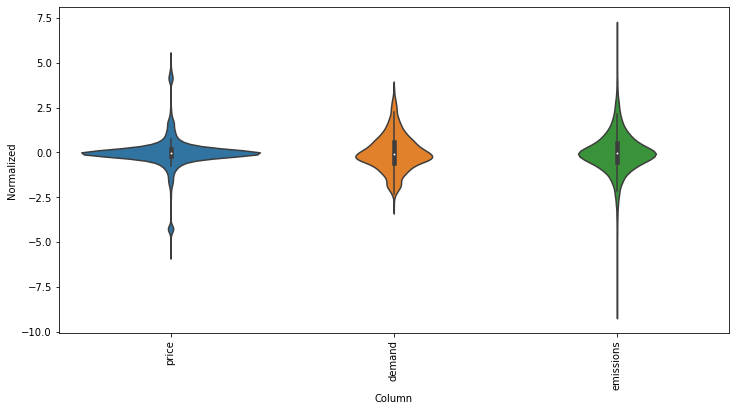

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Creation of Windows

In [15]:
OUT_STEPS = 24
# If no label_columns, TensorFlow will use all the columns
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, test_df=test_df)
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [16]:
example_window = tf.stack([np.array(test_df[:multi_window.total_window_size]),
                           np.array(test_df[100:100+multi_window.total_window_size]),
                           np.array(test_df[200:200+multi_window.total_window_size])
                          ])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 3)
Inputs shape: (3, 24, 3)
Labels shape: (3, 24, 3)


In [17]:
multi_window.example = example_inputs, example_labels

In [18]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None))

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

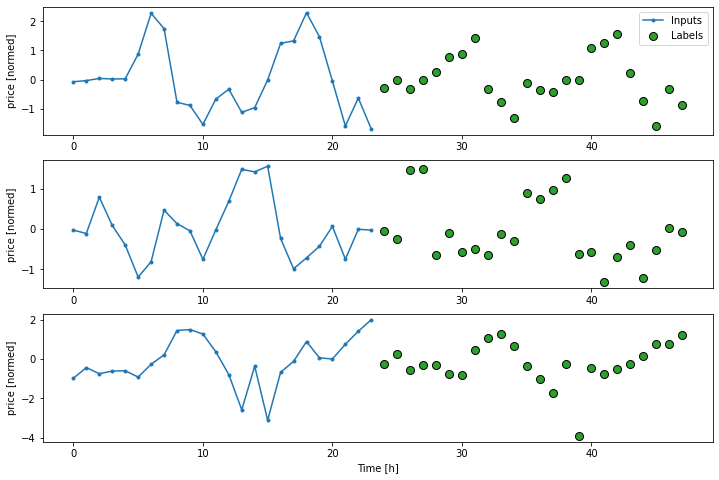

In [19]:
multi_window.plot()
multi_window

# Baseline 1: Repeat last input

54/54 [==============================] - 1s 7ms/step - loss: 3.0079 - root_mean_squared_error: 1.7343


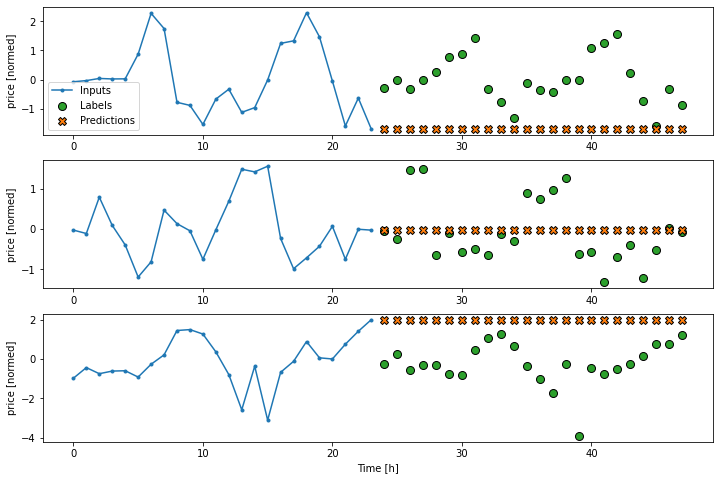

In [21]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.RootMeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.test)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
# Price
multi_window.plot(last_baseline)

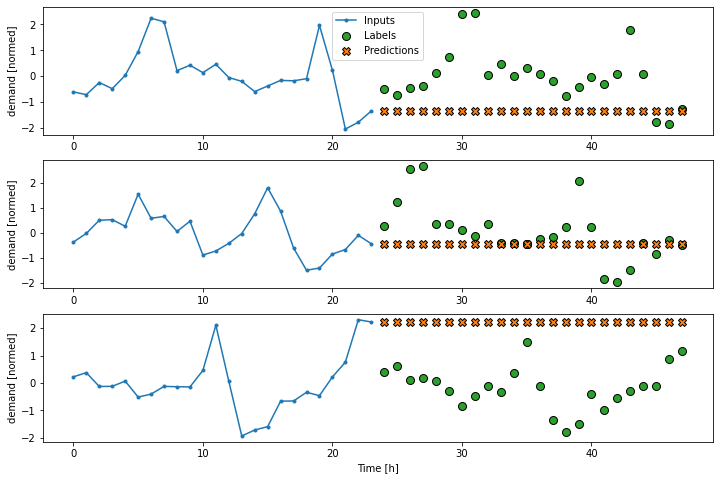

In [27]:
# Demand
multi_window.plot(last_baseline, plot_col='demand')

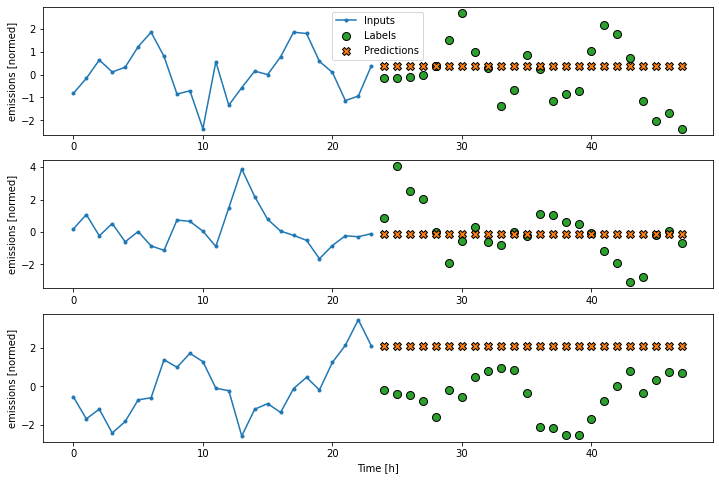

In [28]:
# Emissions
multi_window.plot(last_baseline, plot_col='emissions')

# Baseline 2: Repeat previous 24 hours

54/54 [==============================] - 1s 7ms/step - loss: 0.7540 - mean_absolute_error: 0.5736 - root_mean_squared_error: 0.8683


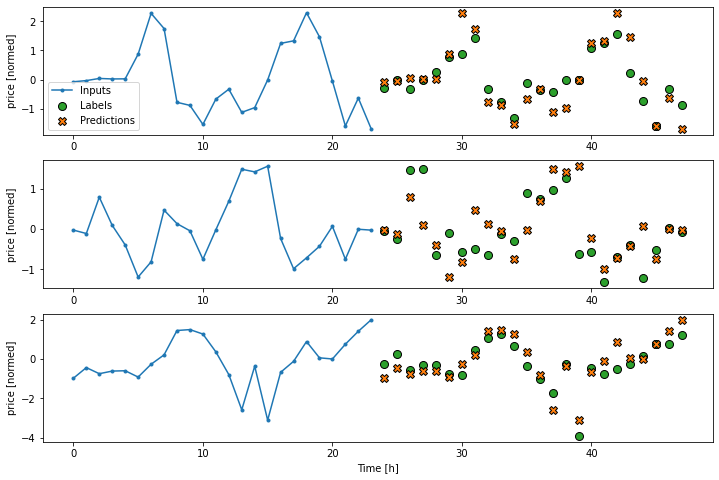

In [23]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

# Price
multi_window.plot(repeat_baseline)

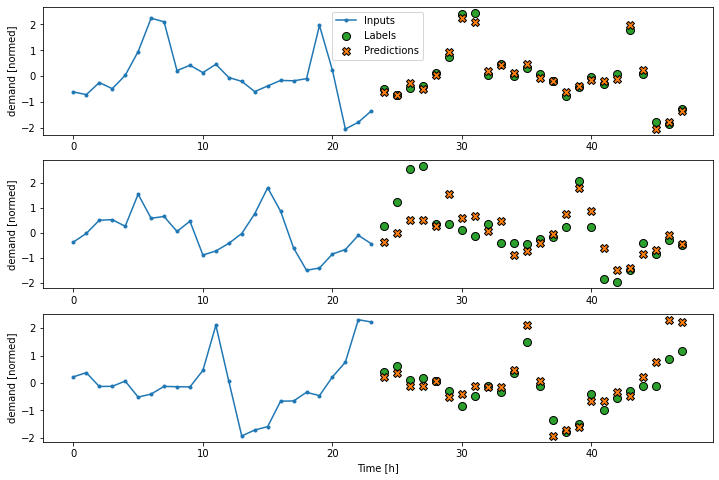

In [25]:
# Demand
multi_window.plot(repeat_baseline, plot_col='demand')

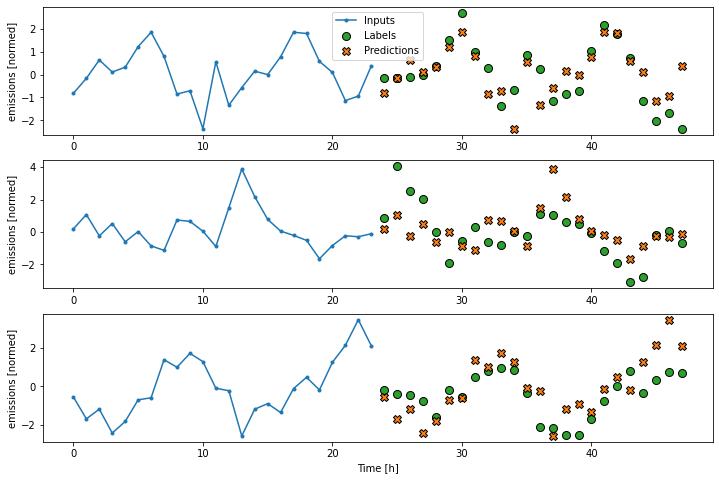

In [26]:
# Emissions
multi_window.plot(repeat_baseline, plot_col='emissions')